<a href="https://colab.research.google.com/github/mrmahiislam/CVPR/blob/main/MID/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Assignment: A comparison of manhattan (L1) and euclidean (L2) distances with 5-fold cross-validation**

 **Name: MD.Mohiminul Islam Mahi**

 **ID: 22-48725-3**

 **Sec: C**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

DATASET_DIR = "/content/drive/My Drive/Colab Notebooks/Assignment-1/animal_dataset"
TRAIN_DIR = DATASET_DIR
IMG_SIZE = 32

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
def load_images_from_folder(base_folder):
    X = []
    y = []
    classes = sorted(os.listdir(base_folder))
    print("Found classes:", classes)

    for class_name in classes:
        class_folder = os.path.join(base_folder, class_name)
        if not os.path.isdir(class_folder):
            continue
        for filename in os.listdir(class_folder):
            file_path = os.path.join(class_folder, filename)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img_resized.flatten())
            y.append(class_name)
    X = np.array(X, dtype=np.float32)
    y = np.array(y)
    print(f"Loaded {X.shape[0]} images. Feature shape: {X.shape}")
    return X, y

X, y_str = load_images_from_folder(TRAIN_DIR)
classes = sorted(list(set(y_str)))
class_to_int = {cls:i for i, cls in enumerate(classes)}
int_to_class = {i:cls for cls,i in class_to_int.items()}
y = np.array([class_to_int[cls] for cls in y_str])

print("Label mapping:")
for cls, enc in class_to_int.items():
    print(f"{cls} -> {enc}")
X = X / 255.0

Found classes: ['cat', 'dog', 'panda']
Loaded 300 images. Feature shape: (300, 1024)
Label mapping:
cat -> 0
dog -> 1
panda -> 2


In [15]:
def knn_predict(X_train, y_train, X_test, k=3, metric='euclidean'):
    y_pred = []
    for xt in X_test:
        if metric == 'euclidean':
            distances = np.sqrt(np.sum((X_train - xt)**2, axis=1))
        elif metric == 'manhattan':
            distances = np.sum(np.abs(X_train - xt), axis=1)
        else:
            raise ValueError("Invalid metric")
        nearest_indices = np.argsort(distances)[:k]
        nearest_labels = y_train[nearest_indices]
        counts = np.bincount(nearest_labels)
        y_pred.append(np.argmax(counts))
    return np.array(y_pred)

def stratified_kfold(X, y, n_splits=5, random_seed=42):
    np.random.seed(random_seed)
    folds = [[] for _ in range(n_splits)]
    for cls in np.unique(y):
        cls_indices = np.where(y == cls)[0]
        np.random.shuffle(cls_indices)
        cls_folds = np.array_split(cls_indices, n_splits)
        for i in range(n_splits):
            folds[i].extend(cls_folds[i])
    return folds

def cross_val_accuracy(X, y, k=3, metric='euclidean', n_splits=5):
    folds = stratified_kfold(X, y, n_splits)
    accuracies = []
    for i in range(n_splits):
        test_idx = np.array(folds[i])
        train_idx = np.array([idx for j in range(n_splits) if j != i for idx in folds[j]])
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        y_pred = knn_predict(X_train, y_train, X_test, k=k, metric=metric)
        acc = np.mean(y_pred == y_test)
        accuracies.append(acc)
    return np.array(accuracies)

In [16]:
k_values = [1, 3, 5, 7, 9, 11]
metrics = ["euclidean", "manhattan"]
results = {metric: [] for metric in metrics}

for metric in metrics:
    print(f"\nDistance Metric: {metric}")
    for k in k_values:
        scores = cross_val_accuracy(X, y, k=k, metric=metric, n_splits=5)
        avg_acc = np.mean(scores)
        results[metric].append(avg_acc)
        print(f"K={k}: fold accuracies={scores}, avg={avg_acc:.4f}")


Distance Metric: euclidean
K=1: fold accuracies=[0.26666667 0.35       0.33333333 0.38333333 0.31666667], avg=0.3300
K=3: fold accuracies=[0.28333333 0.38333333 0.36666667 0.28333333 0.33333333], avg=0.3300
K=5: fold accuracies=[0.33333333 0.38333333 0.31666667 0.38333333 0.4       ], avg=0.3633
K=7: fold accuracies=[0.46666667 0.4        0.33333333 0.36666667 0.36666667], avg=0.3867
K=9: fold accuracies=[0.45       0.41666667 0.31666667 0.36666667 0.35      ], avg=0.3800
K=11: fold accuracies=[0.41666667 0.38333333 0.3        0.4        0.33333333], avg=0.3667

Distance Metric: manhattan
K=1: fold accuracies=[0.28333333 0.4        0.36666667 0.36666667 0.45      ], avg=0.3733
K=3: fold accuracies=[0.33333333 0.35       0.31666667 0.41666667 0.46666667], avg=0.3767
K=5: fold accuracies=[0.33333333 0.4        0.36666667 0.38333333 0.33333333], avg=0.3633
K=7: fold accuracies=[0.43333333 0.4        0.41666667 0.41666667 0.35      ], avg=0.4033
K=9: fold accuracies=[0.41666667 0.38333333

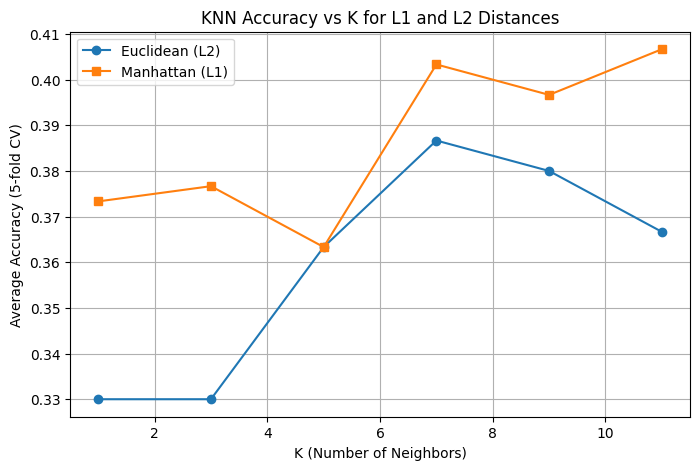


Best configuration:
Distance Metric: manhattan
K: 11
Average CV Accuracy: 0.4067
Final k-NN model trained on all training data.


In [17]:
plt.figure(figsize=(8,5))
plt.plot(k_values, results["euclidean"], marker='o', label='Euclidean (L2)')
plt.plot(k_values, results["manhattan"], marker='s', label='Manhattan (L1)')
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Average Accuracy (5-fold CV)")
plt.title("KNN Accuracy vs K for L1 and L2 Distances")
plt.grid(True)
plt.legend()
plt.show()

best_k, best_metric, best_acc = None, None, -1
for metric in metrics:
    for k, acc in zip(k_values, results[metric]):
        if acc > best_acc:
            best_acc = acc
            best_k = k
            best_metric = metric

print(f"\nBest configuration:")
print(f"Distance Metric: {best_metric}")
print(f"K: {best_k}")
print(f"Average CV Accuracy: {best_acc:.4f}")
y_pred_final = knn_predict(X, y, X, k=best_k, metric=best_metric)
print("Final k-NN model trained on all training data.")

# **Discussion**

- Using 5-fold cross-validation, Manhattan (L1) distance performed better than Euclidean (L2) for this dataset, achieving the highest accuracy with K = 11.

- The dataset has 3 grayscale classes (32×32 images), which reduces computation but may lose fine details, and some classes have overlapping features.

- Manhattan (L1) is better suited here because it handles small variations in pixel values more robustly.

- Limitations: small image size, k-NN sensitivity to K, and increased computation with larger datasets.

- Potential improvements: use feature extraction (HOG, PCA), higher resolution, data augmentation, or advanced classifiers (SVM, CNN).


Top 5 Predictions:
True: dog, Predicted: dog
True: dog, Predicted: dog
True: dog, Predicted: cat
True: dog, Predicted: dog
True: dog, Predicted: dog


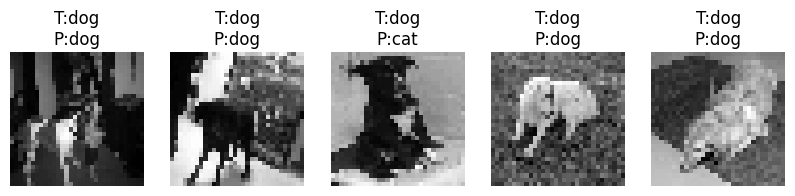

In [13]:
sample_indices = random.sample(range(X.shape[0]), 5)
X_sample = X[sample_indices]
y_sample_true = y[sample_indices]

y_pred_sample = knn_predict(X, y, X_sample, k=best_k, metric=best_metric)
y_pred_labels = [int_to_class[i] for i in y_pred_sample]
y_true_labels = [int_to_class[i] for i in y_sample_true]

print("\nTop 5 Predictions:")
for i in range(5):
    print(f"True: {y_true_labels[i]}, Predicted: {y_pred_labels[i]}")

plt.figure(figsize=(10,2))
for i, idx in enumerate(sample_indices):
    plt.subplot(1,5,i+1)
    plt.imshow(X[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"T:{y_true_labels[i]}\nP:{y_pred_labels[i]}")
    plt.axis('off')
plt.show()